### Libraries

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
import random
import pickle

from skimage.io import imread
from skimage.io import imshow
import skimage.transform as trans
from skimage import exposure

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, log_loss, roc_curve, auc
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.utils import resample
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder


import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
from keras.models import load_model


### Section 1. Data Loading, Data Insights & Further Preprocessing

In [2]:
#Preparation of complete dataset without downsampled size

#For simplicity in our code for splitting -
#the test_data set from the original Kaggle datasets have been merged with the train_set

train_path = 'Alzheimer_s Dataset/train'
test_path = 'Alzheimer_s Dataset/test'

categories = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

train_images = []
classImages = []

#Number of train_images of each category for our train_data
numberofimages = []

#similar to rmarkdown to get file directories
for category in categories:
    data_train_path = os.path.join(train_path, category)
    data_test_path = os.path.join(test_path, category)

    #store the number of images for each label in a list
    numberofimages.append(len(os.listdir(data_train_path)))

    for file in os.listdir(data_train_path):
        train_image_paths = os.path.join(data_train_path, file) #image in this case refers to title of the image
        train_image = imread(train_image_paths, as_gray=True) #reads an image, imread - image + read and grayscales all train_images
        train_images.append(train_image)

In [34]:
# Number of images for each data label / category within training data
print(numberofimages)

[3200, 2240, 896, 64]


In [3]:
# Splitting of training dataset into a list of its respective categories
NonDemented = train_images[0:3200]
VeryMildDemented = train_images[3200:5440]
MildDemented = train_images[5440:6336]
ModerateDemented = train_images[6336:]

lst = [NonDemented, VeryMildDemented, MildDemented, ModerateDemented]

In [36]:
#Check dimensions of each raw data set
print(NonDemented[0].shape)

#Check if all data-set has the same dimensions
dim = train_images[0].shape
sum_of_incorrect = 0
for i in train_images:
    if i.shape != dim:
        sum_of_incorrect+=1
print(sum_of_incorrect)

(208, 176)
0


We can see that there is a significant class imbalance which calls for the need of data augmentation

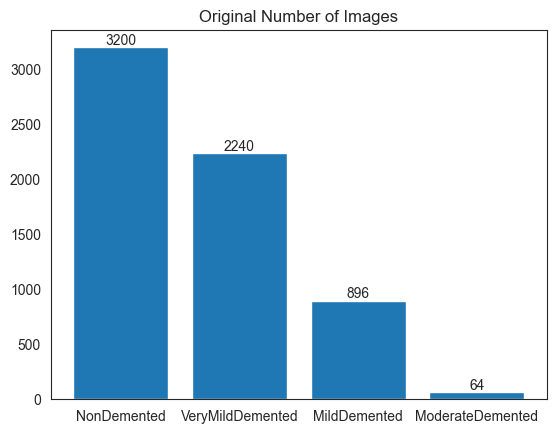

In [37]:
#Plot showing class imbalance
sns.set_style('white')
barplot = plt.bar(categories, numberofimages)
plt.title('Original Number of Images')
plt.bar_label(barplot , labels = numberofimages)
plt.show()

#### Data Augmentations

In [4]:
#Data Augmentations of ModerateDemented
new_ModerateDemented = []
for i in ModerateDemented:
  new_ModerateDemented.append(trans.rotate(i, 12))
  new_ModerateDemented.append(trans.rotate(i, 348))
  new_ModerateDemented.append(trans.rotate(i, 5))
  new_ModerateDemented.append(trans.rotate(i,355))
  new_ModerateDemented.append(trans.rotate(i, 10))
  new_ModerateDemented.append(trans.rotate(i, 350))
  new_ModerateDemented.append(trans.rotate(i, 8))
  new_ModerateDemented.append(trans.rotate(i, 362))
  new_ModerateDemented.append(trans.rotate(i, 3))
  new_ModerateDemented.append(trans.rotate(i,357))
  new_ModerateDemented.append(trans.rotate(i[::-1], 180))

print(len(new_ModerateDemented))# amount new data points augmented

ModerateDemented += new_ModerateDemented#added new data into ModerateDemented
numberofimages[3] += len(new_ModerateDemented)#updated numbers for image
print(numberofimages) #Number of new images for dataset 1

704
[3200, 2240, 896, 768]


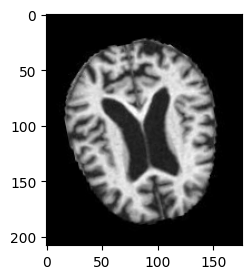

In [39]:
#Showing example of our image augmentation which keeps roughly the similar orientation
plt.style.use('default')
plt.figure(figsize= (3,3))
plt.imshow(new_ModerateDemented[0], cmap = 'gray')
plt.show()

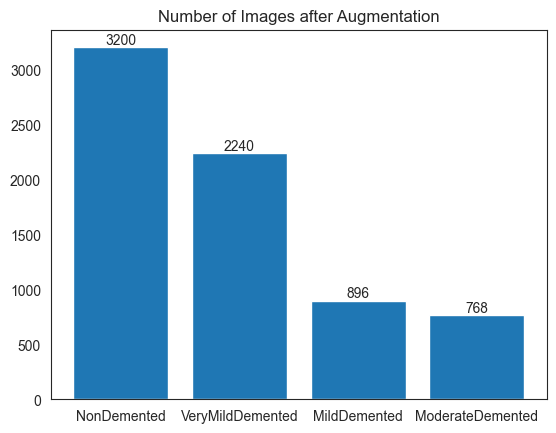

In [40]:
#Data Visualization after augmentation
sns.set_style('white')
barplot = plt.bar(categories, numberofimages)
plt.title('Number of Images after Augmentation')
plt.bar_label(barplot , labels = numberofimages)
plt.show()

#### Downsampling
Even with augmentation (image pre-processing), there is an excessive amount of NonDemented and VeryMildDemented. We can perform downsampling to speed up computationational speed and reduce data over-representation while keeping the general pattern.

In [5]:
downsampled_NonDemented = resample(NonDemented, replace= False, n_samples= len(MildDemented) + 700, random_state=9)
downsampled_VeryMildDemented = resample(VeryMildDemented, replace= False, n_samples= len(MildDemented) + 300, random_state= 9)

#new list for downsampled dataset
downsampled_lst = [downsampled_NonDemented, downsampled_VeryMildDemented, MildDemented, ModerateDemented]

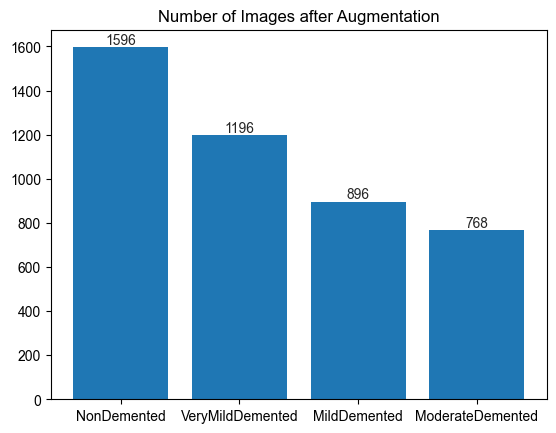

In [9]:
new_numberofimages = [len(downsampled_NonDemented), len(downsampled_VeryMildDemented), len(MildDemented), len(ModerateDemented)]
barplot = plt.bar(categories, new_numberofimages )
sns.set_style('white')
plt.title('Number of Images after Augmentation')
plt.bar_label(barplot , labels = new_numberofimages )
plt.show()

#### Image visualization and adjustments

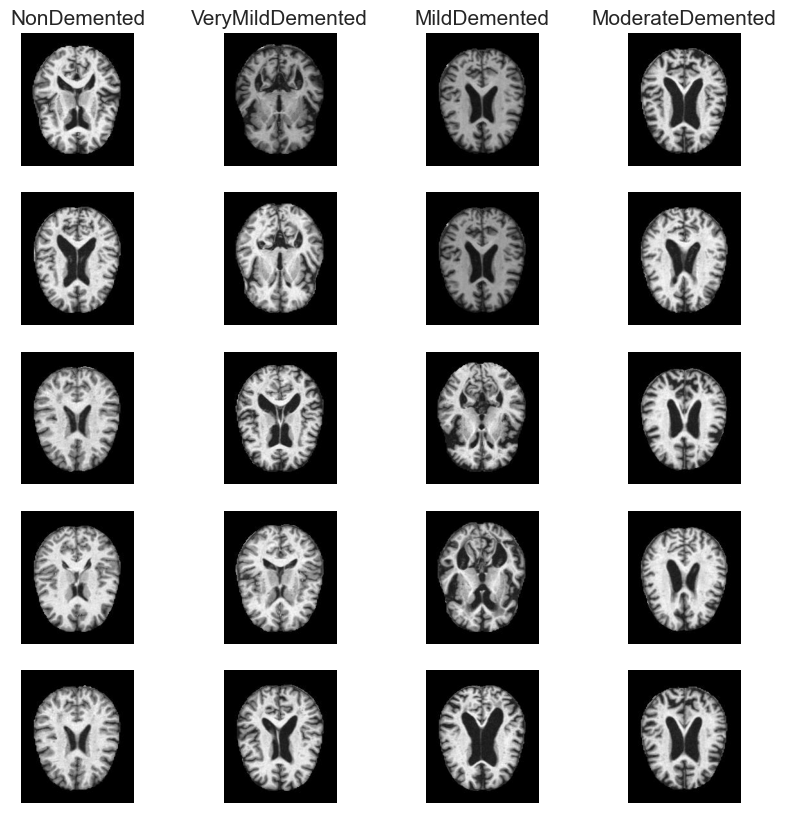

In [43]:
#First 4 pictures to roughly show how each MRI Scan for each category looks like using the original dataset

fig,axes = plt.subplots(5,4, figsize = (10,10))

for i in range(len(lst)):
    for j in range(5):
        img = lst[i][j]
        axes[j,i].imshow(img, cmap = 'gray')
        axes[j,i].axis('off') #turn off axis for each subplot
axes[0,0].set_title('NonDemented', fontsize = 15)
axes[0,1].set_title('VeryMildDemented', fontsize = 15)
axes[0,2].set_title('MildDemented', fontsize = 15)
axes[0,3].set_title('ModerateDemented', fontsize = 15)
plt.show()

The above pictures show us that some images are darker than others.
We can do intensity normalization via adaptive histogram equalization (adaptive to ensure contrast amongst images are not too big).

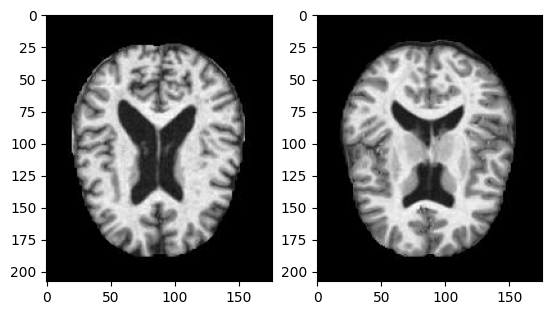

In [97]:
#Original images for first two NonDemented Images to show massive contrast difference
plt.style.use('default')
fig, axes = plt.subplots(1,2)
axes[0].imshow(NonDemented[1], cmap = 'gray')
axes[1].imshow(NonDemented[100], cmap = 'gray')
plt.show()

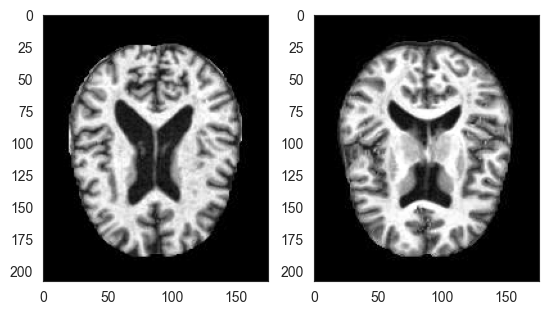

In [95]:
#After adaptive histogram equalization
fig, axes = plt.subplots(1,2)
img = NonDemented[1]
img2 = NonDemented[100]

img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.007, nbins = 200)
img2_adapteq = exposure.equalize_adapthist(img2, clip_limit= 0.007)


axes[0].imshow(img_adapteq, cmap = 'gray')
axes[1].imshow(img2_adapteq, cmap = 'gray')
plt.show()

In [6]:
#Performing histogram equalization for all images
for cat in downsampled_lst:
    for imgidx in range(len(cat)):
        cat[imgidx] = exposure.equalize_adapthist(cat[imgidx], clip_limit = 0.007)



Let's now analyse the the pixels of a 'mean' image of 60 images from each class with a scale of [0,1]


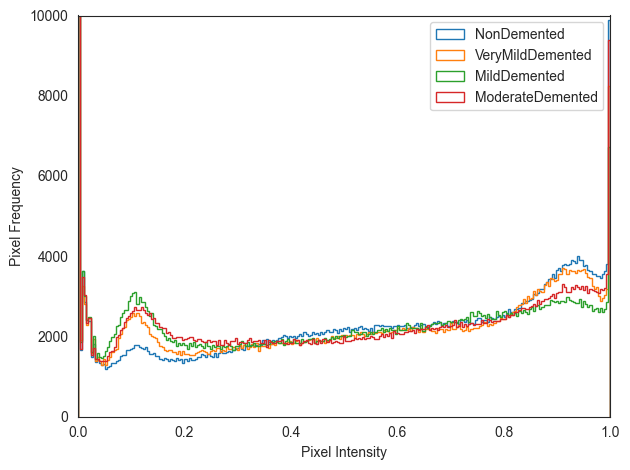

In [138]:
mean_pixels = []
for cat in downsampled_lst:
    total = 0
    flat = []
    for j in range(30):
        total += cat[j] / 30
        flat.extend(cat[j].flatten())
    mean_pixels.append(flat)

for i in range(len(mean_pixels)):
    plt.hist(mean_pixels[i], bins = 255, histtype = 'step')
    plt.xlim([0,1])
    plt.ylim([0,10000])

sns.set_style('white')
plt.xlabel('Pixel Intensity')
plt.ylabel('Pixel Frequency')
plt.legend(categories)
plt.tight_layout()
plt.show()

In [7]:
#Applying binary mask to all images
newBinaryImages = []
newBinaryImages_flat = []
for cat in downsampled_lst:
    for img in cat:
        img1 = np.array(img)
        #Binary mask
        img1 = np.where((img1 >= 0.06) & (img1<= 0.30), 1,0)
        newBinaryImages.append(img1)
        newBinaryImages_flat.append(img1.flatten())

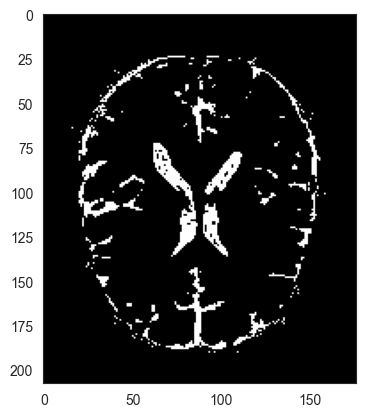

In [51]:
#Image after binary mask application
plt.imshow(newBinaryImages[10], cmap = 'gray')
plt.show()

### Section 2. Dataset Preparation for Model Training

#### Preparation for Linear Model

In [10]:
#Creating raw data labels
labels = []
for i in range(len(categories)):
    labels.extend(np.repeat(categories[i], new_numberofimages[i]))

Creating one-hot encoded labels for classification

In [11]:
classificationLabels = np.where(np.array(labels) == 'NonDemented', 0, 1)

We will create two subsets of data based on the original training set --  the training set is further split into a smaller training set and a validation set such that cross-validation can be performed.

The first set contains the original unedited base images.

The second set contains images with a binary mask.

In [12]:
#In our downsamples list, we will create flat matrices of the original image
baseImagesFlat = []
for cat in downsampled_lst:
    for image in cat:
        baseImagesFlat.append(image.flatten())

#Flat binary images have already been made above
#newBinaryImages_flat

In [13]:
baseX_train, baseX_test, baseY_train, baseY_test = train_test_split(baseImagesFlat, classificationLabels, test_size= 0.20, random_state= 9) # 10% Of our data acts as a validation set
binaryX_train, binaryX_test, binaryY_train, binaryY_test = train_test_split(newBinaryImages_flat, classificationLabels, test_size= 0.20, shuffle=True, random_state= 9)

In [101]:
#Checking if all X_train have same dimensions

for i in baseX_train:
    if len(i) != 36608:
        print('y')

for i in binaryX_train:
    if len(i) != 36608:
        print('y')

One potential improvement is by performing LDA on our dataset to speed up linear model training time. Additionally, LDA helps increase linear separability in our data, and mitigates the curse of dimensionality since we are dealing with complex image data, therefore reducing the dimensionality of the data.

We will do this on our base-images rather than binary images since binary images have less features.

In [14]:
lda = LinearDiscriminantAnalysis()
lda_baseX_train = lda.fit_transform(baseX_train, baseY_train)
lda_baseX_test = lda.transform(baseX_test)


#### Preparation for CNN Model and mcSVM models

We will create two subsets of training data based on the original training set. Similar to the above, one with a binary mask and one without only for the mcSVM dataSet

The first will be the training set for our deep-learning model without a binary mask.

The second will be the training set for our multi-class SVM model for classification of images strictly representing demented data.

In [15]:
#CNN data
baseImages3D = []
for cat in downsampled_lst:
    for image in cat:
        baseImages3D.append(image)

baseImages3D = np.array(baseImages3D).reshape(-1, 208,176,1)
newBinaryImages3D = np.array(newBinaryImages).reshape(-1,208,176,1)

In [16]:
labelsGet = pd.get_dummies(labels)
cnn_labels = labelsGet.values

In [17]:
#mcSVM dataset
#Here, we will remove NonDemented datasets
mcSVM_images = []
for cat in downsampled_lst[1:]:
    for images in cat:
        mcSVM_images.append(images.flatten())

mcSVM_lab = []
for i in range(len(categories)-1):
    mcSVM_lab.extend(np.repeat(categories[i+1], new_numberofimages[i+1]))

le = LabelEncoder()
le.fit(mcSVM_lab)

mcSVM_labels = le.transform(mcSVM_lab)

#binary_images for mc_SVM
binary_mcSVM = newBinaryImages_flat[1596:]

In [18]:
mcSVM_X_train, mcSVM_X_test, mcSVM_y_train, mcSVM_y_test = train_test_split(mcSVM_images, mcSVM_labels, random_state= 9)
mcSVM_binary_X_train, mcSVM_binary_X_test, mcSVM_binary_y_train, mcSVM_binary_y_test = train_test_split(binary_mcSVM, mcSVM_labels, random_state= 9)

cnn_X_train, cnn_X_test, cnn_y_train, cnn_y_test = train_test_split(baseImages3D, cnn_labels, test_size= 0.2, random_state= 9)

### Section 3. Model Training

#### Linear Models for Dectection (Binary Classification)

Models will follow this format: Base set, Binary set, LDA set using a KFold of 5. For models using base_images(except LDA), we will tune the hyper-parameters as it will likely have maximum iteration problems without converging by using RandomizedSearchCV

In [78]:
#Default is 5
kf = KFold()

##### Logistic Regression Models

In [81]:
logregBase_parameters = {'penalty': ['l1','l2'], 'C': list(np.linspace(0.00001,2, num = 7))}

#run logistic regression models
logregBase = RandomizedSearchCV(LogisticRegression(random_state = 9,max_iter = 500), logregBase_parameters, cv = 5) 
logregBase.fit(baseX_train,baseY_train)

logregBinary = LogisticRegressionCV(cv = kf, random_state= 9)
logregBinary.fit(binaryX_train, binaryY_train)

logregLDA = LogisticRegressionCV(cv = kf, random_state= 9)
logregLDA.fit(lda_baseX_train, baseY_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

LogisticRegressionCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                     random_state=9)

In [47]:
with open ('logregBase.pkl', 'rb') as file:
    lrBase = pickle.load(file)

with open ('logregBinary.pkl', 'rb') as file:
    lrBinary = pickle.load(file)

with open ('logregLDA.pkl', 'rb') as file:
    lrLDA = pickle.load(file)

In [50]:
lrBase_ypred_test = lrBase.predict(baseX_test)
lrBase_ypred_train = lrBase.predict(baseX_train)

In [102]:
print(f"Base Logistic Regression Prediction Probability: {np.mean(lrBase_ypred)}")
print(f"Actual Probability: {np.mean(baseY_test)}")

print(f"Binary Logistic Regression Prediction Probability: {np.mean(lrBinary_ypred)}")
print(f"Actual Probability: {np.mean(binaryY_test)}")

print(f"LDA Logistic Regression Prediction Probability: {np.mean(lrLDA_ypred)}")
print(f"Actual Probability: {np.mean(baseY_test)}")

Base Logistic Regression Prediction Probability: 0.649103139013453
Actual Probability: 0.6401345291479821
Binary Logistic Regression Prediction Probability: 0.655829596412556
Actual Probability: 0.6401345291479821
LDA Logistic Regression Prediction Probability: 0.6334080717488789
Actual Probability: 0.6401345291479821


Results

Checking for Model Fit

Bias-Variance Trade-off

In [58]:
#Evaluating the model via evaluative metrics

print("Base Logistic Regression Metrics for Training Data")

logregBase_cm_train = confusion_matrix(baseY_train, lrBase_ypred_train)
print(logregBase_cm_train)

print(classification_report(baseY_train, lrBase_ypred_train))

print("Base Logistic Regression Metrics for Test Data")

logregBase_cm_test = confusion_matrix(baseY_test, lrBase_ypred_test)
print(logregBase_cm_test)

print(classification_report(baseY_test, lrBase_ypred_test))

Base Logistic Regression Metrics for Training Data
[[1191   84]
 [  57 2232]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1275
           1       0.96      0.98      0.97      2289

    accuracy                           0.96      3564
   macro avg       0.96      0.95      0.96      3564
weighted avg       0.96      0.96      0.96      3564

Base Logistic Regression Metrics for Test Data
[[302  19]
 [ 11 560]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       321
           1       0.97      0.98      0.97       571

    accuracy                           0.97       892
   macro avg       0.97      0.96      0.96       892
weighted avg       0.97      0.97      0.97       892



In [104]:
logregBase_residuals_train = baseY_train - lrBase_ypred_train
logregBase_var_train = np.var(logregBase_residuals_train)
print(f"Logistic Regression Base Variance (Training Data): {logregBase_var_train}")

logregBase_residuals_test = baseY_test - lrBase_ypred_test
logregBase_var_test = np.var(logregBase_residuals_test)
print(f"Logistic Regression Base Variance (Test Data): {logregBase_var_test}")

Logistic Regression Base Variance (Training Data): 0.039504897459442904
Logistic Regression Base Variance (Test Data): 0.033551851032596676


In [65]:
logregBase_train_loss = log_loss(baseY_train, lrBase_ypred_train)
print(f"Logistic Regression Base Loss (Train): {logregBase_train_loss}")

logregBase_test_loss = log_loss(baseY_test, lrBase_ypred_test)
print(f"Logistic Regression Base Loss (Test): {logregBase_test_loss}")

Logistic Regression Base Loss (Train): 1.4259694522630524
Logistic Regression Base Loss (Test): 1.21223049514968


In [49]:
lrBase_validation_scores = cross_val_score(lrBase, baseX_test, baseY_test, cv=5, scoring='accuracy')
print(lrBase_validation_scores.mean())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

KeyboardInterrupt: 

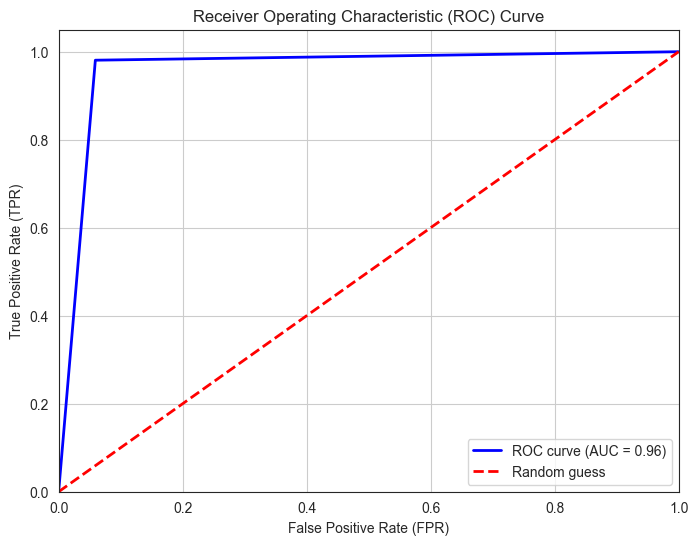

In [103]:
#ROC-AUC curve
logregBase_fpr, logregBase_tpr, logregBase_thresholds = roc_curve(baseY_test, lrBase_ypred_test)
roc_auc = auc(logregBase_fpr, logregBase_tpr)

plt.figure(figsize=(8, 6))
plt.plot(logregBase_fpr, logregBase_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [105]:
lrBinary_ypred_test = lrBinary.predict(binaryX_test)
lrBinary_ypred_train = lrBinary.predict(binaryX_train)

In [107]:
print("Binary Logistic Regression Metrics for Training Data")

logregBinary_cm_train = confusion_matrix(binaryY_train, lrBinary_ypred_train)
print(logregBinary_cm_train)

print(classification_report(binaryY_train, lrBinary_ypred_train))

print("Binary Logistic Regression Metrics for Test Data")

logregBinary_cm_test = confusion_matrix(binaryY_test, lrBinary_ypred_test)
print(logregBinary_cm_test)

print(classification_report(binaryY_test, lrBinary_ypred_test))

Binary Logistic Regression Metrics for Training Data
[[1149  126]
 [  82 2207]]
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      1275
           1       0.95      0.96      0.95      2289

    accuracy                           0.94      3564
   macro avg       0.94      0.93      0.94      3564
weighted avg       0.94      0.94      0.94      3564

Binary Logistic Regression Metrics for Test Data
[[292  29]
 [ 15 556]]
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       321
           1       0.95      0.97      0.96       571

    accuracy                           0.95       892
   macro avg       0.95      0.94      0.95       892
weighted avg       0.95      0.95      0.95       892



In [109]:
logregBinary_residuals_train = baseY_train - lrBinary_ypred_train
logregBinary_var_train = np.var(logregBinary_residuals_train)
print(f"Binary Logistic Regression Variance (Training Data): {logregBinary_var_train}")

logregBinary_residuals_test = baseY_test - lrBinary_ypred_test
logregBinary_var_test = np.var(logregBinary_residuals_test)
print(f"Binary Logistic Regression Variance (Test Data): {logregBinary_var_test}")

Binary Logistic Regression Variance (Training Data): 0.05820897590444918
Binary Logistic Regression Variance (Test Data): 0.04908101912365018


In [112]:
logregBinary_loss_train = log_loss(binaryY_train, lrBinary_ypred_train)
print(f"Logistic Regression Binary Loss (Train): {logregBinary_loss_train}")

logregBinary_loss_test = log_loss(binaryY_test, lrBinary_ypred_test)
print(f"Logistic Regression Binary Loss (Test): {logregBinary_loss_test}")

Logistic Regression Binary Loss (Train): 2.1035577735511692
Logistic Regression Binary Loss (Test): 1.777938059552864


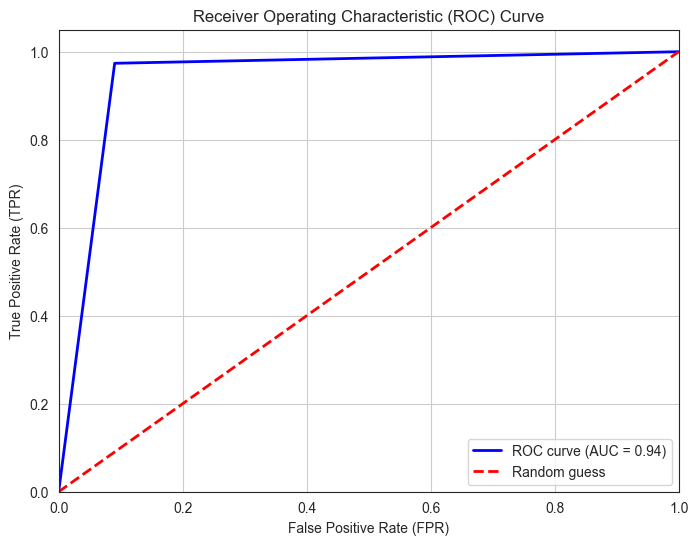

In [113]:
#ROC-AUC curve
logregBinary_fpr, logregBinary_tpr, logregBinary_thresholds = roc_curve(baseY_test, lrBinary_ypred_test)
roc_auc = auc(logregBinary_fpr, logregBinary_tpr)

plt.figure(figsize=(8, 6))
plt.plot(logregBinary_fpr, logregBinary_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
#plt.show()

In [114]:
lrLDA_ypred_test = lrLDA.predict(lda_baseX_test)
lrLDA_ypred_train = lrLDA.predict(lda_baseX_train)

In [117]:
lda_cm_train = confusion_matrix(baseY_train, lrLDA_ypred_train)
print(lda_cm_train)

print(classification_report(baseY_train, lrLDA_ypred_train))

lda_cm_test = confusion_matrix(baseY_test, lrLDA_ypred_test)
print(lda_cm_test)

print(classification_report(baseY_test, lrLDA_ypred_test))

[[1264   11]
 [  15 2274]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1275
           1       1.00      0.99      0.99      2289

    accuracy                           0.99      3564
   macro avg       0.99      0.99      0.99      3564
weighted avg       0.99      0.99      0.99      3564

[[274  47]
 [ 53 518]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       321
           1       0.92      0.91      0.91       571

    accuracy                           0.89       892
   macro avg       0.88      0.88      0.88       892
weighted avg       0.89      0.89      0.89       892



In [120]:
logregLDA_residuals_train = baseY_train - lrLDA_ypred_train
logregLDA_var_train = np.var(logregLDA_residuals_train)
print(f"Logistic Regression Base Variance (Training Data): {logregLDA_var_train}")

logregLDA_residuals_test = baseY_test - lrLDA_ypred_test
logregLDA_var_test = np.var(logregLDA_residuals_test)
print(f"Logistic Regression Base Variance (Test Data): {logregLDA_var_test}")

Logistic Regression Base Variance (Training Data): 0.00729391432721025
Logistic Regression Base Variance (Test Data): 0.11206237808924371


In [125]:
logregLDA_loss_train = log_loss(baseY_train, lrLDA_ypred_train)
print(f"LDA Logistic Regression Loss (Train): {logregLDA_loss_train}")

logregLDA_loss_test = log_loss(baseY_test, lrLDA_ypred_test)
print(f"LDA Logistic Regression Loss (Test): {logregLDA_loss_test}")

LDA Logistic Regression Loss (Train): 0.2629447216938964
LDA Logistic Regression Loss (Test): 4.0407683171656


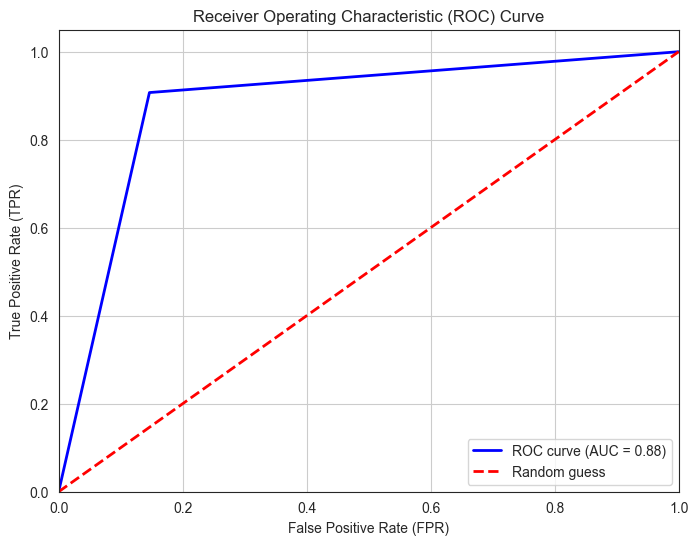

In [121]:
#ROC-AUC curve
logregLDA_fpr, logregLDA_tpr, logregLDA_thresholds = roc_curve(baseY_test, lrLDA_ypred_test)
roc_auc = auc(logregLDA_fpr, logregLDA_tpr)

plt.figure(figsize=(8, 6))
plt.plot(logregLDA_fpr, logregLDA_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

##### SVM Models using Linear Kernel

In [118]:
base_svm = LinearSVC(max_iter = 500)
base_svm.fit(baseX_train, baseY_train)

binary_svm = LinearSVC(max_iter = 500)
binary_svm.fit(binaryX_train, binaryY_train)

lda_svm = LinearSVC()
lda_svm.fit(baseX_train, baseY_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the w

LinearSVC()

In [21]:
with open ('base_svm.pkl', 'rb') as file:
    baseSVM = pickle.load(file)

with open ('binary_svm.pkl', 'rb') as file:
    binarySVM = pickle.load(file)

with open ('lda_svm.pkl', 'rb') as file:
    ldaSVM = pickle.load(file)

In [80]:
baseSVM_ypred_train = baseSVM.predict(baseX_train)
baseSVM_ypred_test = baseSVM.predict(baseX_test)

In [29]:
print(f"Base SVM Prediction Probability: {np.mean(baseSVM_ypred)}")
print(f"Actual Probability: {np.mean(baseY_test)}")

binarySVM_ypred = binarySVM.predict(binaryX_test)
print(f"Binary SVM Prediction Probability: {np.mean(binarySVM_ypred)}")
print(f"Actual Probability: {np.mean(binaryY_test)}")

ldaSVM_ypred = ldaSVM.predict(baseX_test)
print(f"LDA SVM Prediction Probability: {np.mean(ldaSVM_ypred)}")
print(f"Actual Probability: {np.mean(baseY_test)}")

Base SVM Prediction Probability: 0.649103139013453
Actual Probability: 0.6401345291479821
Binary SVM Prediction Probability: 0.6547085201793722
Actual Probability: 0.6401345291479821
LDA SVM Prediction Probability: 0.647982062780269
Actual Probability: 0.6401345291479821


In [82]:
print("Base SVM Metrics for Training Data")

svmBase_cm_train = confusion_matrix(baseY_train, baseSVM_ypred_train)
print(svmBase_cm_train)

print(classification_report(baseY_train, baseSVM_ypred_train))

print("Base SVM Metrics for Test Data")

svmBase_cm_test = confusion_matrix(baseY_test, baseSVM_ypred_test)
print(svmBase_cm_test)

print(classification_report(baseY_test, baseSVM_ypred_test))

Base SVM Metrics for Training Data
[[1196   79]
 [  41 2248]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1275
           1       0.97      0.98      0.97      2289

    accuracy                           0.97      3564
   macro avg       0.97      0.96      0.96      3564
weighted avg       0.97      0.97      0.97      3564

Base SVM Metrics for Test Data
[[303  18]
 [ 10 561]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       321
           1       0.97      0.98      0.98       571

    accuracy                           0.97       892
   macro avg       0.97      0.96      0.97       892
weighted avg       0.97      0.97      0.97       892



In [84]:
base_SVM_residuals_train = baseY_train - baseSVM_ypred_train
base_SVM_var_train = np.var(base_SVM_residuals_train)
print(f"Base SVM Variance (Train): {base_SVM_var_train}")

base_SVM_residuals_test = baseY_test - baseSVM_ypred_test
base_SVM_var_test = np.var(base_SVM_residuals_test)
print(f"Base SVM Variance (Test): {base_SVM_var_test}")

Base SVM Variance (Train): 0.033556351644641956
Base SVM Variance (Test): 0.03130969856622896


In [89]:
base_SVM_decision_scores_train = baseSVM.decision_function(baseX_train)
base_SVM_hinge_loss_train = np.maximum(0, 1 - baseSVM_ypred_train * base_SVM_decision_scores_train).mean()
print(f"Base SVM Hinge Loss (Train): {base_SVM_hinge_loss_train}")

base_SVM_decision_scores_test = baseSVM.decision_function(baseX_test)
base_SVM_hinge_loss_test = np.maximum(0, 1 - baseSVM_ypred_test * base_SVM_decision_scores_test).mean()
print(f"Base SVM Hinge Loss (Test): {base_SVM_hinge_loss_test}")

Base SVM Hinge Loss (Train): 0.38873271479348104
Base SVM Hinge Loss (Test): 0.38456076623892926


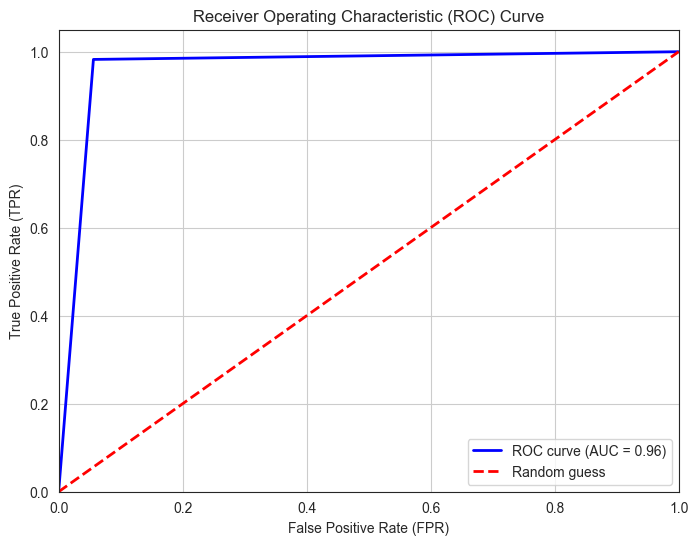

In [90]:
#ROC-AUC curve
baseSVM_fpr, baseSVM_tpr, baseSVM_thresholds = roc_curve(baseY_test, baseSVM_ypred_test)
roc_auc = auc(baseSVM_fpr, baseSVM_tpr)

plt.figure(figsize=(8, 6))
plt.plot(baseSVM_fpr, baseSVM_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [91]:
binarySVM_ypred_train = binarySVM.predict(binaryX_train)
binarySVM_ypred_test = binarySVM.predict(binaryX_test)

In [94]:
print("Binary SVM Metrics for Training Data")

svmBinary_cm_train = confusion_matrix(binaryY_train, binarySVM_ypred_train)
print(svmBinary_cm_train)

print(classification_report(binaryY_train, binarySVM_ypred_train))

print("Binary SVM Metrics for Test Data")

svmBinary_cm_test = confusion_matrix(binaryY_test, binarySVM_ypred_test)
print(svmBinary_cm_test)

print(classification_report(binaryY_test, binarySVM_ypred_test))

Binary SVM Metrics for Training Data
[[1160  115]
 [  73 2216]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      1275
           1       0.95      0.97      0.96      2289

    accuracy                           0.95      3564
   macro avg       0.95      0.94      0.94      3564
weighted avg       0.95      0.95      0.95      3564

Binary SVM Metrics for Test Data
[[292  29]
 [ 16 555]]
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       321
           1       0.95      0.97      0.96       571

    accuracy                           0.95       892
   macro avg       0.95      0.94      0.94       892
weighted avg       0.95      0.95      0.95       892



In [96]:
binary_SVM_residuals_train = baseY_train - binarySVM_ypred_train
binary_SVM_var_train = np.var(binary_SVM_residuals_train)
print(f"Base SVM Variance (Train): {binary_SVM_var_train}")

binary_SVM_residuals_test = baseY_test - binarySVM_ypred_test
binary_SVM_var_test = np.var(binary_SVM_residuals_test)
print(f"Base SVM Variance (Test): {binary_SVM_var_test}")

Base SVM Variance (Train): 0.05261084469838679
Base SVM Variance (Test): 0.050236029278690496


In [98]:
binary_SVM_decision_scores_train = binarySVM.decision_function(baseX_train)
binary_SVM_hinge_loss_train = np.maximum(0, 1 - binarySVM_ypred_train * binary_SVM_decision_scores_train).mean()
print(f"Binary SVM Hinge Loss (Train): {binary_SVM_hinge_loss_train}")

binary_SVM_decision_scores_test = binarySVM.decision_function(baseX_test)
binary_SVM_hinge_loss_test = np.maximum(0, 1 - binarySVM_ypred_test * binary_SVM_decision_scores_test).mean()
print(f"Binary SVM Hinge Loss (Test): {binary_SVM_hinge_loss_test}")

Binary SVM Hinge Loss (Train): 0.34595959595959597
Binary SVM Hinge Loss (Test): 0.3452914798206278


0.9408181525552264


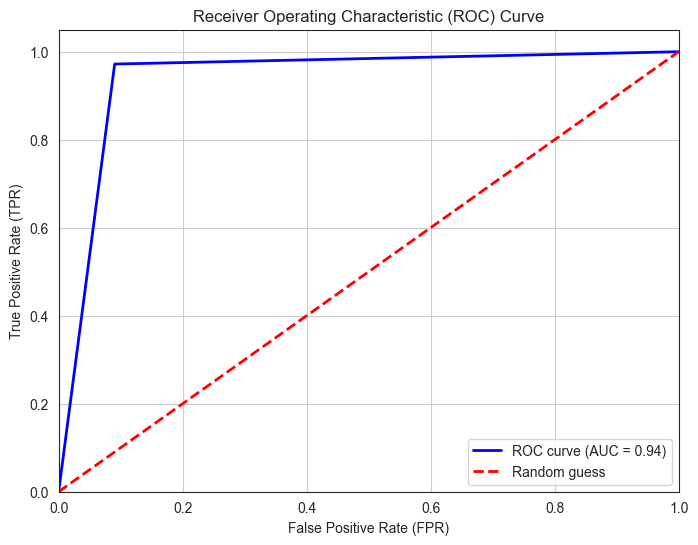

In [99]:
#ROC-AUC curve
binarySVM_fpr, binarySVM_tpr, binarySVM_thresholds = roc_curve(baseY_test, binarySVM_ypred_test)
binarySVM_roc_auc = auc(binarySVM_fpr, binarySVM_tpr)
print(binarySVM_roc_auc)

plt.figure(figsize=(8, 6))
plt.plot(binarySVM_fpr, binarySVM_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % binarySVM_roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [131]:
ldaSVM_ypred_train = ldaSVM.predict(baseX_train)
ldaSVM_ypred_test = ldaSVM.predict(baseX_test)

In [132]:
svmLDA_cm_train = confusion_matrix(baseY_train, ldaSVM_ypred_train)
print(svmLDA_cm_train)

print(classification_report(baseY_train, ldaSVM_ypred_train))

svmLDA_cm_test = confusion_matrix(baseY_test, ldaSVM_ypred_test)
print(svmLDA_cm_test)

print(classification_report(baseY_test, ldaSVM_ypred_test))

[[1207   68]
 [  46 2243]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1275
           1       0.97      0.98      0.98      2289

    accuracy                           0.97      3564
   macro avg       0.97      0.96      0.97      3564
weighted avg       0.97      0.97      0.97      3564

[[304  17]
 [ 10 561]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       321
           1       0.97      0.98      0.98       571

    accuracy                           0.97       892
   macro avg       0.97      0.96      0.97       892
weighted avg       0.97      0.97      0.97       892



In [134]:
lda_SVM_residuals_train = baseY_train - ldaSVM_ypred_train
lda_SVM_var_train = np.var(lda_SVM_residuals_train)
print(f"LDA Logistic Regression Variance (Training Data): {lda_SVM_var_train}")

lda_SVM_residuals_test = baseY_test - ldaSVM_ypred_test
lda_SVM_var_test = np.var(lda_SVM_residuals_test)
print(f"LDA Logistic Regression Variance (Test Data): {lda_SVM_var_test}")

LDA Logistic Regression Variance (Training Data): 0.031948428038963014
LDA Logistic Regression Variance (Test Data): 0.03020747451185425


In [136]:
lda_SVM_decision_scores_train = ldaSVM.decision_function(baseX_train)
lda_SVM_hinge_loss_train = np.maximum(0, 1 - ldaSVM_ypred_train * lda_SVM_decision_scores_train).mean()
print(f"LDA SVM Hinge Loss (Train): {lda_SVM_hinge_loss_train}")

lda_SVM_decision_scores_test = ldaSVM.decision_function(baseX_test)
lda_SVM_hinge_loss_test = np.maximum(0, 1 - ldaSVM_ypred_test * lda_SVM_decision_scores_test).mean()
print(f"LDA SVM Hinge Loss (Test): {lda_SVM_hinge_loss_test}")

LDA SVM Hinge Loss (Train): 0.3925783811063803
LDA SVM Hinge Loss (Test): 0.38775255010449583


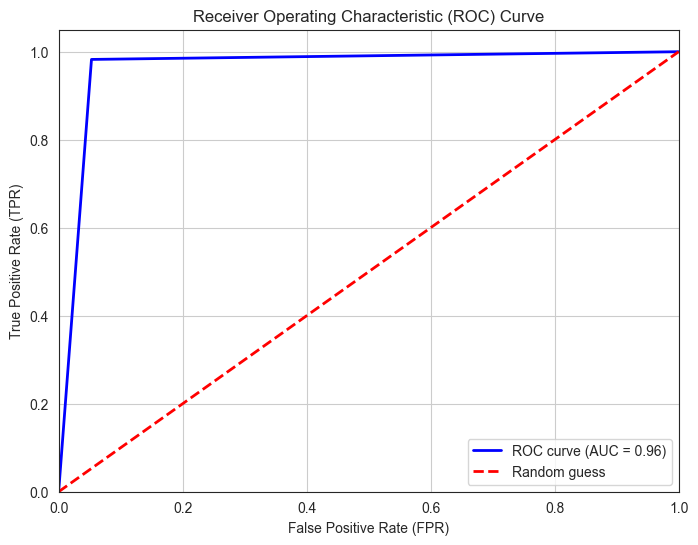

In [138]:
#ROC-AUC curve
ldaSVM_fpr, ldaSVM_tpr, ldaSVM_thresholds = roc_curve(baseY_test, ldaSVM_ypred_test)
roc_auc = auc(ldaSVM_fpr, ldaSVM_tpr)

plt.figure(figsize=(8, 6))
plt.plot(ldaSVM_fpr, ldaSVM_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Save trained models into pickle file for re-use

In [ ]:
import pickle

pickle.dump(logregBase , open('logregBase.pkl' , 'wb'))
pickle.dump(logregBinary , open('logregBinary.pkl' , 'wb'))
pickle.dump(logregLDA, open('logregLDA.pkl' , 'wb'))


pickle.dump(base_svm , open('base_svm.pkl' , 'wb'))
pickle.dump(binary_svm , open('binary_svm.pkl' , 'wb'))
pickle.dump(lda_svm , open('lda_svm.pkl' , 'wb'))

#### mcSVM Models for Classification of Severity

We will train using two different kernels and check the classification report. Kernels used are rbf and polynomial

In [158]:
rbf = SVC(kernel = 'rbf')
poly = SVC(kernel = 'poly')

rbfBinary = SVC(kernel = 'rbf') #we will only be using rbf kernel for binary to target specific locations

In [159]:
rbf.fit(mcSVM_X_train, mcSVM_y_train)

poly.fit(mcSVM_X_train, mcSVM_y_train)

rbfBinary.fit(mcSVM_binary_X_train, mcSVM_binary_y_train)

SVC()

In [28]:
with open ('poly.pkl', 'rb') as file:
    polySVM = pickle.load(file)

with open ('rbf.pkl', 'rb') as file:
    rbfSVM = pickle.load(file)

with open ('rbfBinary.pkl', 'rb') as file:
    rbfBinarySVM = pickle.load(file)

In [147]:
polySVM_ypred_train = polySVM.predict(mcSVM_X_train)
polySVM_ypred_test = polySVM.predict(mcSVM_X_test)

In [146]:
print(f"Poly SVM Prediction Probability: {np.mean(polySVM_ypred)}")
print(f"Actual Probability: {np.mean(baseY_test)}")

rbfSVM_ypred = rbfSVM.predict(mcSVM_X_test)
print(f"RBF SVM Prediction Probability: {np.mean(rbfSVM_ypred)}")
print(f"Actual Probability: {np.mean(binaryY_test)}")

rbfBinarySVM_ypred = rbfBinarySVM.predict(mcSVM_binary_X_test)
print(f"Binary RBF SVM Prediction Probability: {np.mean(rbfBinarySVM_ypred)}")
print(f"Actual Probability: {np.mean(baseY_test)}")

Poly SVM Prediction Probability: 1.137062937062937
Actual Probability: 0.6401345291479821
RBF SVM Prediction Probability: 1.165034965034965
Actual Probability: 0.6401345291479821
Binary RBF SVM Prediction Probability: 1.067132867132867
Actual Probability: 0.6401345291479821


In [151]:
print("Poly Multiclass SVM Metrics for Training Data")
poly_cm_train = confusion_matrix(mcSVM_y_train, polySVM_ypred_train)
print(poly_cm_train)
print(classification_report(polySVM_ypred_train, mcSVM_y_train))

print("Poly Multiclass SVM Metrics for Test Data")
poly_cm_test = confusion_matrix(mcSVM_y_test, polySVM_ypred_test)
print(poly_cm_test)
print(classification_report(poly_ypred, mcSVM_y_test))

Poly Multiclass SVM Metrics for Training Data
[[679   0   2]
 [  0 593   0]
 [ 11   0 860]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       690
           1       1.00      1.00      1.00       593
           2       0.99      1.00      0.99       862

    accuracy                           0.99      2145
   macro avg       0.99      0.99      0.99      2145
weighted avg       0.99      0.99      0.99      2145

Poly Multiclass SVM Metrics for Test Data
[[215   0   0]
 [  0 175   0]
 [  6   0 319]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       221
           1       1.00      1.00      1.00       175
           2       0.98      1.00      0.99       319

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



In [154]:
poly_residuals_train = mcSVM_y_train - polySVM_ypred_train
poly_var_train = np.var(poly_residuals_train)
print(f"Poly Multiclass SVM Variance (Training Data): {poly_var_train}")

poly_residuals_test = mcSVM_y_test - polySVM_ypred_test
poly_var_test = np.var(poly_residuals_test)
print(f"Poly Multiclass SVM Variance (Test Data): {poly_var_test}")

Poly Multiclass SVM Variance (Training Data): 0.024172005151026126
Poly Multiclass SVM Variance (Test Data): 0.03328475720084113


In [160]:
rbf_ypred = rbf.predict(mcSVM_X_test)
classification_report(rbf_ypred, mcSVM_y_test)

'              precision    recall  f1-score   support\n\n           0       0.83      0.86      0.85       206\n           1       1.00      1.00      1.00       175\n           2       0.91      0.89      0.90       334\n\n    accuracy                           0.91       715\n   macro avg       0.91      0.92      0.92       715\nweighted avg       0.91      0.91      0.91       715\n'

In [ ]:
rbfBinary_ypred = rbfBinary.predict(mcSVM_binary_X_test)
classification_report(rbfBinary_ypred, mcSVM_binary_y_test)

'              precision    recall  f1-score   support\n\n           0       0.92      0.95      0.93       209\n           1       1.00      1.00      1.00       175\n           2       0.97      0.95      0.96       331\n\n    accuracy                           0.96       715\n   macro avg       0.96      0.97      0.96       715\nweighted avg       0.96      0.96      0.96       715\n'

In [ ]:
pickle.dump(rbf , open('rbf.pkl' , 'wb'))
pickle.dump(poly , open('poly.pkl' , 'wb'))
pickle.dump(rbfBinary, open('rbfBinary.pkl' , 'wb'))


#### Overall Method using Deep-Learning

#### CNN Model for Detection & Classification

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (208,176,1), padding = 'same'))
model.add(layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.1)) #regularization

model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.1))


model.add(layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.1))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.BatchNormalization())


model.add(layers.Dense(4, activation='softmax'))

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 208, 176, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 208, 176, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 104, 88, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 104, 88, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 104, 88, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 104, 88, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 52, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 52, 44, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 52, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 26, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 26, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 26, 22, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 26, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 13, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 13, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 13, 11, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 13, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7680)           │             

 Total params: 15,565,470 (59.38 MB)

 Trainable params: 5,187,700 (19.79 MB)

 Non-trainable params: 2,368 (9.25 KB)

 Optimizer params: 10,375,402 (39.58 MB)

In [ ]:
opt = keras.optimizers.Adam(learning_rate = 0.0008)
model.compile(optimizer= opt, loss= 'categorical_crossentropy', metrics= ['accuracy', 'precision', 'recall'])

In [ ]:
history = model.fit(cnn_X_train, cnn_y_train, epochs = 10)

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 99s 833ms/step - accuracy: 0.4587 - loss: 1.4185 - precision: 0.5021 - recall: 0.3604
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 98s 876ms/step - accuracy: 0.6900 - loss: 0.7242 - precision: 0.7659 - recall: 0.5991
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 102s 915ms/step - accuracy: 0.7516 - loss: 0.5916 - precision: 0.8047 - recall: 0.6903
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 103s 923ms/step - accuracy: 0.8053 - loss: 0.4691 - precision: 0.8439 - recall: 0.7680
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 106s 950ms/step - accuracy: 0.8592 - loss: 0.3672 - precision: 0.8786 - recall: 0.8314
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 104s 927ms/step - accuracy: 0.8891 - loss: 0.2979 - precision: 0.9068 - recall: 0.8712
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 103s 919ms/step - accuracy: 0.8747 - loss: 0.3351 - precision: 0.8879 - recall: 0.8587
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 103s 922ms/step - accuracy: 0.9339 - loss: 0.2070 - precision: 0.9390 - r

In [ ]:
model.save('cnnh5.h5')

In [145]:
cnn = load_model('cnnh5.h5')
opt = keras.optimizers.Adam(learning_rate = 0.0008)
cnn.compile(optimizer= opt, loss= 'categorical_crossentropy', metrics= ['accuracy', 'precision', 'recall'])
cnn_metrics = cnn.fit(cnn_X_train, cnn_y_train, epochs = 10)

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 709ms/step - accuracy: 0.8372 - loss: 0.4323 - precision: 0.8514 - recall: 0.8271
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 726ms/step - accuracy: 0.8939 - loss: 0.2709 - precision: 0.9064 - recall: 0.8845
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 79s 703ms/step - accuracy: 0.9268 - loss: 0.2060 - precision: 0.9335 - recall: 0.9223
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 741ms/step - accuracy: 0.9512 - loss: 0.1462 - precision: 0.9533 - recall: 0.9453
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 88s 782ms/step - accuracy: 0.9613 - loss: 0.1237 - precision: 0.9652 - recall: 0.9560
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 89s 792ms/step - accuracy: 0.9631 - loss: 0.1113 - precision: 0.9662 - recall: 0.9603
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 89s 796ms/step - accuracy: 0.9660 - loss: 0.1029 - precision: 0.9694 - recall: 0.9636
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 89s 799ms/step - accuracy: 0.9639 - loss: 0.1089 - precision: 0.9664 - recall: